 # -- Dataset: USDA (Abbreviated) SR 28 --
## URL: [USDA (Abbreviated) SR 28 ](https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/methods-and-application-of-food-composition-laboratory/mafcl-site-pages/sr11-sr28/)

## Documentation: [SR 28 PDF](https://www.ars.usda.gov/ARSUserFiles/80400535/Data/SR/sr28/sr28_doc.pdf)

> Regression vs. Classification models of predicting Vitamin C content
based on other nutrients present.







In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    # !pip install category_encoders==2.*
    !pip install category_encoders
    !pip install pandas-profiling==2.*


In [2]:
## Import Modules ##
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.tree import DecisionTreeClassifier, plot_tree ## ERRORS?
from sklearn.ensemble import RandomForestClassifier ## ERRORS?
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ModuleNotFoundError: ignored

# I. Exploration - Stock Read Statement

In [ ]:
## Import your link here ##
data_path = "/content/drive/MyDrive/Colab Notebooks/Custom_Data_Sets/USDA (Abbreviated) SR 28_CB_Subset_UTF.csv"
og_df = pd.read_csv(data_path)
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDB_No             8790 non-null   int64  
 1   Shrt_Desc          8790 non-null   object 
 2   Water_(g)          8789 non-null   float64
 3   Energ_Kcal         8790 non-null   int64  
 4   Protein_(g)        8790 non-null   float64
 5   Lipid_Tot_(g)      8790 non-null   float64
 6   Ash_(g)            8465 non-null   float64
 7   Carbohydrt_(g)     8790 non-null   float64
 8   Fiber_TD_(g)       8196 non-null   float64
 9   Sugar_Tot_(g)      6958 non-null   float64
 10  Calcium_(mg)       8442 non-null   float64
 11  Iron_(mg)          8646 non-null   float64
 12  Magnesium_(mg)     8051 non-null   float64
 13  Phosphorus_(mg)    8211 non-null   float64
 14  Potassium_(mg)     8364 non-null   float64
 15  Sodium_(mg)        8707 non-null   float64
 16  Zinc_(mg)          8084 

In [ ]:
## Inspection 1: It seems like there are a few amount of rows with missing data??##
empty_row_mask = og_df[og_df.isnull().any(axis=1)]
print(f'There are {empty_row_mask.shape[0]} rows with NaN values in them')
print(f' That is {100*(round(empty_row_mask.shape[0]/(len(og_df)), 2))}% of the data, leaving {round(len(og_df)*.25)} Usable rows!')
print("Given the nature of the columns... an imputation using the mean seems cumbersome ")
print(f'Train Set: {round((len(og_df)*.25) * .60)}, Val Set: {round((len(og_df)*.25) * .20)}, Test Set: {round((len(og_df)*.25) * .20)} ')
## Let's drop these rows in wrangle and check the profile..

There are 6566 rows with NaN values in them
 That is 75.0% of the data, leaving 2198 Usable rows!
Given the nature of the columns... an imputation using the mean seems cumbersome 
Train Set: 1318, Val Set: 440, Test Set: 440 


In [ ]:
## Inspection 2: Dropping 75% of the rows seems a bit much. Perhaps we can identify columns with the most NaN values... ##
og_df['GmWt_2'].isnull().sum()             
empty_col_count = [og_df[col].isnull().sum() for col in og_df.columns
                  if og_df[col].isnull().sum() > 0]
percent_of_data = .10 # adjust this parameter to drop more or less columns...
empty_threshold = len(og_df) * percent_of_data
empty_max_cols = [col for col in og_df.columns
                  if og_df[col].isnull().sum() > empty_threshold]

print(f"There are {len(empty_col_count)} columns with NaN values; \n However, only " 
      f"{len(empty_max_cols)} columns have more than {empty_threshold} NaN values... ")

There are 47 columns with NaN values; 
 However, only 25 columns have more than 879.0 NaN values... 


In [ ]:
## Pandas Profile Report ##
Report = ProfileReport(og_df,minimal=True).to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

# II. Baseline Regression Model (BEFORE any Data is Wrangled) ** Special Note **

>  Here we've discovered after future steps that Vitamin C may be
an interesting column to predict. However, because our columns are full of NaN
values, we may impute these to zeroes (even though we have no evidence that
this is a logicial correlation)

**Per Documentation:** "If a value is not
present for any particular nutrient, that does not indicate that the value should be zero
or any other value—only that no value is available in SR."

> Also, we must transform (or in this case, drop) the object columns before we attempt a standard regression
model...





In [ ]:
def basic_wrangle(data_path):
  df = pd.read_csv(data_path,  
                   index_col= 'NDB_No') ## Set Index (Unique) -- Is a Unique index col still calculated??

  ## Fill NaN values with 0
  df.fillna(0, inplace=True)

  # Drop columns that are objects...
  obj_cols = [col for col in df.select_dtypes('object').columns]
  df.drop(columns= obj_cols, inplace=True)
  
  return df
df = basic_wrangle(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 1001 to 93600
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Water_(g)          8790 non-null   float64
 1   Energ_Kcal         8790 non-null   int64  
 2   Protein_(g)        8790 non-null   float64
 3   Lipid_Tot_(g)      8790 non-null   float64
 4   Ash_(g)            8790 non-null   float64
 5   Carbohydrt_(g)     8790 non-null   float64
 6   Fiber_TD_(g)       8790 non-null   float64
 7   Sugar_Tot_(g)      8790 non-null   float64
 8   Calcium_(mg)       8790 non-null   float64
 9   Iron_(mg)          8790 non-null   float64
 10  Magnesium_(mg)     8790 non-null   float64
 11  Phosphorus_(mg)    8790 non-null   float64
 12  Potassium_(mg)     8790 non-null   float64
 13  Sodium_(mg)        8790 non-null   float64
 14  Zinc_(mg)          8790 non-null   float64
 15  Copper_mg)         8790 non-null   float64
 16  Manganese_(mg)     8

In [ ]:
target = 'Vit_C_(mg)' ## Prediction Col
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

In [ ]:
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)
print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 12.8257680966969


In [ ]:
## Linear Regression Model ##
model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
print('model_lr MAE for training', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('model_lr MAE for val',mean_absolute_error(y_val, model_lr.predict(X_val)) )

model_lr MAE for training 16.413867013135974
model_lr MAE for val 18.84611862064482


In [ ]:
## Standard Ridge Regression Model ##
model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)
print('model_std_r MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('model_std_r MAE for val',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

model_std_r MAE for training 16.408683931519413
model_std_r MAE for val 18.840070475177424


In [ ]:
## Ridge Regression Model -- Set TUNE to '1'' to run!!##
## ALPHA TUNE ##
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune = 1
factor = 1 ## Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)
range_max = 1000
while tune == True:
  for i in range (0,range_max):
    model_r = Ridge(alpha=(i*factor)) # Iterates Alpha hyperparameter
    model_r.fit(X_train,y_train)
    r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
    r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
    last_mae_val.append(r_mae_val)
    if (i % (1000)) == 0: ## Printing for big iterations
      print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))
    if r_mae_val < base_mae: ## Returning the first best alpha
      best_low_alpha = i*factor
      print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
      tune == False
    if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
      best_low_alpha = (i-1)*factor
      print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
      tune = False
      if tune == False and cont.lower().strip() != 'y':
        cont = input("\nWould you like to continue? y/n: ")
        if cont.lower().strip() != 'n':
          tune = True
        else:  
          best_low_alpha = i*factor
          print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
          tune = False
          break
    if int(i) == range_max-1:
      tune = False
      break

## BEST Ridge Regression Model with Best Alpha ##
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0
r_mae_train: 16.41386701313738
r_mae_val: 18.846118620646823
last_mae_val: 164.500327270248
None

-- BEST Ridge Model--
best_low_alpha: 0
r_mae_val:18.846118620646823
base_mae: 12.8257680966969


Index(['Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)',
       'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Sugar_Tot_(g)', 'Calcium_(mg)',
       'Iron_(mg)', 'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)',
       'Sodium_(mg)', 'Zinc_(mg)', 'Copper_mg)', 'Manganese_(mg)',
       'Selenium_(µg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)',
       'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)',
       'Vit_B12_(µg)', 'Vit_A_IU', 'Vit_A_RAE', 'Retinol_(µg)',
       'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)',
       'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU',
       'Vit_K_(µg)', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'GmWt_2', 'Refuse_Pct'],
      dtype='object') 48 = 48


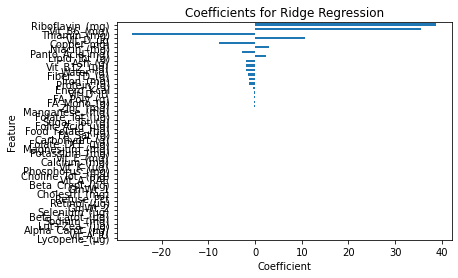

In [ ]:
## Ridge Model Coefficients ## -- Model is actually worse... Can we try limiting to two features...?
coefficients = model_r.coef_
features = X.columns ## model_r.named_steps['ridge'].get_feature_names() 
print(features, len(features), "=", len(coefficients)) ## VERIFY!
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(len(X)).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

In [ ]:
## Keeping track of model performance ##
model_mae_val = []
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val}, \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823], 
baseline mae: 12.8257680966969


# III. Wrangle Data - First Experiments

In [ ]:
def wrangle(data_path):
  df = pd.read_csv(data_path,  
                   index_col= 'NDB_No') ## Set Index (Unique) -- Is a Unique index col still calculated??

  ## Drop Constant Columns
  cons_cols = [col for col in df.columns
              if df[col].nunique() == 1]
  df.drop(columns=cons_cols, inplace=True)
  print("Constant Columns Dropped:", cons_cols)

  ## Drop Columns Missing Over 90% of the Data ##
  percent_of_data = .10 # adjust this parameter to drop more or less columns...
  empty_threshold = len(df) * percent_of_data
  empty_max_cols = [col for col in df.columns
                    if df[col].isnull().sum() > empty_threshold]
  df.drop(columns=empty_max_cols, inplace=True)
  print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

   ## Drop Columns Missing Half of the Data ##
  cutoff = int(len(df)/2)
  empty_cols = [col for col in df.columns
               if (df[col].isnull().sum() > cutoff)]
  df.drop(columns=empty_cols, inplace=True)
  print("Columns Dropped with Over Half Missing Values:", empty_cols)

  ## Drop HCCCs
  cutoff = 100
  hcc_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  uni_cols = [col for col in df.columns
              if df[col].nunique() == len(df)]
  df.drop(columns= hcc_cols + uni_cols, inplace=True)
  print("High Cardinality Columns Dropped:", hcc_cols, 
        "\nUnique Columns Dropped:", uni_cols)
  
  ## Drop Rows that have NaN Values ## -- 
  og_rows = len(df)
  df = df.dropna()
  print(og_rows - len(df), 'rows with NaN values dropped!!')

  ##Special Drops that are half-empty, HCC, or Unique:
  
  return df
df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: []
2267 rows with NaN values dropped!!


In [ ]:
## What columns are left after Wrangle??##
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 1001 to 93600
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Water_(g)        6523 non-null   float64
 1   Energ_Kcal       6523 non-null   int64  
 2   Protein_(g)      6523 non-null   float64
 3   Lipid_Tot_(g)    6523 non-null   float64
 4   Ash_(g)          6523 non-null   float64
 5   Carbohydrt_(g)   6523 non-null   float64
 6   Fiber_TD_(g)     6523 non-null   float64
 7   Calcium_(mg)     6523 non-null   float64
 8   Iron_(mg)        6523 non-null   float64
 9   Magnesium_(mg)   6523 non-null   float64
 10  Phosphorus_(mg)  6523 non-null   float64
 11  Potassium_(mg)   6523 non-null   float64
 12  Sodium_(mg)      6523 non-null   float64
 13  Zinc_(mg)        6523 non-null   float64
 14  Vit_C_(mg)       6523 non-null   float64
 15  Thiamin_(mg)     6523 non-null   float64
 16  Riboflavin_(mg)  6523 non-null   float64
 17  Niacin_(mg

In [ ]:
## RERUN Pandas Profile Report ##
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# IV. Split Data into Train, Val, and Test Set

> We will try and precit the Vitamin C content in regards to all other features.






In [ ]:
target = 'Vit_C_(mg)' ## Prediction Col
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# V. Regression Task (Numerical Predictions)

> We are choosing MAE rather than Accuracy because this is not classification




In [ ]:
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)
print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 13.282972880851371


# VI. Build Models

> No data needs to be imputed or catagorical data transformed.
We will begin with Linear Regression



In [ ]:
## Linear Regression Model ##
model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
print('model_lr MAE for training', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('model_lr MAE for val',mean_absolute_error(y_val, model_lr.predict(X_val)) )

model_lr MAE for training 14.276920136203733
model_lr MAE for val 16.413444990033526


In [ ]:
## Standard Ridge Regression Model ##
model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)
print('model_std_r MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('model_std_r MAE for val',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

model_std_r MAE for training 14.27141021929458
model_std_r MAE for val 16.40799041171919


In [ ]:
## Ridge Regression Model -- Set TUNE to '1'' to run!!##
## ALPHA TUNE ##
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune = 1
factor = 10000 ## Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)
range_max = 100000
while tune == True:
  for i in range (0,range_max):
    model_r = Ridge(alpha=(i*factor)) # Iterates Alpha hyperparameter
    model_r.fit(X_train,y_train)
    r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
    r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
    last_mae_val.append(r_mae_val)
    if (i % (1000)) == 0: ## Printing for big iterations
      print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))
    if r_mae_val < base_mae: ## Returning the first best alpha
      best_low_alpha = i*factor
      print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
      tune == False
    if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
      best_low_alpha = (i-1)*factor
      print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
      tune = False
      if tune == False and cont.lower().strip() != 'y':
        cont = input("\nWould you like to continue? y/n: ")
        if cont.lower().strip() != 'n':
          tune = True
        else:  
          best_low_alpha = i*factor
          print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
          tune = False
          break
    if int(i) == range_max-1:
      tune = False
      break

## BEST Ridge Regression Model with Best Alpha ##
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0
r_mae_train: 14.276920136203659
r_mae_val: 16.413444990033454
last_mae_val: 176.43736855343298
None

LAST MAE VAL HIGHER!! 
 best_low_alpha: 560000
last_mae_val: 13.67951627547677
r_mae_val: 13.67970857786769

Would you like to continue? y/n: n

--FINAL--
best_low_alpha: 570000
last_mae_val: 13.67951627547677
r_mae_val: 13.67970857786769

-- BEST Ridge Model--
best_low_alpha: 570000
r_mae_val:13.67970857786769
base_mae: 13.282972880851371


In [ ]:
## Ridge Regression Model -- Set TUNE to '1'' to run!!##
## MAX ITERATIONS TUNE ## -- Doesn't seem like this has any real effect??
best_low_iter, last_mae_val, cont = 0, [base_mae**2], 'start'
tune = 1
factor = 1 ## Change in multiples of ten to process Max Iterations faster (.10,1,10,100,etc.)
range_max = 100
while tune == True:
  for i in range (0,range_max):
    model_r = Ridge(max_iter=(i*factor), alpha=best_low_alpha) # Iterates Max Iterations hyperparameter
    model_r.fit(X_train,y_train)
    r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
    r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
    last_mae_val.append(r_mae_val)
    if (i % (1000)) == 0: ## Printing for big iterations
      print(print(f"\nI'm Still Running!!\nMax Iterations: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))
    if r_mae_val < base_mae: ## Returning the first best Max Iterations
      best_low_iter = i*factor
      print(f"\nbest_low_iter: {best_low_iter}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
      tune == False
    if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
      best_low_iter = (i-1)*factor
      print(f"\nLAST MAE VAL HIGHER!! \n best_low_iter: {best_low_iter}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
      tune = False
      if tune == False and cont.lower().strip() != 'y':
        cont = input("\nWould you like to continue? y/n: ")
        if cont.lower().strip() != 'n':
          tune = True
        else:  
          best_low_iter = i*factor
          print(f"\n--FINAL--\nbest_low_iter: {best_low_iter}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
          tune = False
          break
    if int(i) == range_max-1:
      tune = False
      break

## BEST Ridge Regression Model with Best Max Iterations ##
model_r = Ridge(alpha=(best_low_alpha), max_iter=best_low_iter)
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}\nbest_low_iter: {best_low_iter}")




I'm Still Running!!
Max Iterations: 0
r_mae_train: 11.31656175800777
r_mae_val: 13.67970857786769
last_mae_val: 176.43736855343298
None

-- BEST Ridge Model--
best_low_alpha: 570000
r_mae_val:13.67970857786769
base_mae: 13.282972880851371
best_low_iter: 0


# VII. Evaluate Coefficients

Index(['Water_(g)', 'Energ_Kcal', 'Protein_(g)', 'Lipid_Tot_(g)', 'Ash_(g)',
       'Carbohydrt_(g)', 'Fiber_TD_(g)', 'Calcium_(mg)', 'Iron_(mg)',
       'Magnesium_(mg)', 'Phosphorus_(mg)', 'Potassium_(mg)', 'Sodium_(mg)',
       'Zinc_(mg)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)',
       'Vit_A_IU', 'FA_Sat_(g)', 'FA_Mono_(g)', 'FA_Poly_(g)',
       'Cholestrl_(mg)', 'GmWt_1', 'Refuse_Pct'],
      dtype='object') 24 = 24


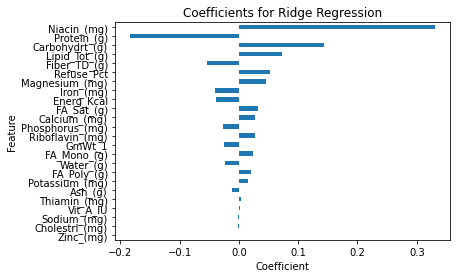

In [ ]:
## Ridge Model Coefficients ##
coefficients = model_r.coef_
features = X.columns ## model_r.named_steps['ridge'].get_feature_names() 
print(features, len(features), "=", len(coefficients)) ## VERIFY!
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(len(X)).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

In [ ]:
## BEST Features in regards to Prediction Column ##
best_feat_cols = ['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', target]

## Keeping track of model performance ##
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val}, \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823, 13.67970857786769], 
baseline mae: 13.282972880851371


#VIII. First Impressions

> It is possible that we have too many features not very dependent on what we are trying to predict. We will try to reduce the number of columns in our new set and only the top (4) features.



# IX. ReWragle the Data and repeat all above steps

In [ ]:
def wrangle(data_path):
  df = pd.read_csv(data_path,  
                   index_col= 'NDB_No') ## Set Index (Unique) -- Is a Unique index col still calculated??

  ## Drop Constant Columns
  cons_cols = [col for col in df.columns
              if df[col].nunique() == 1]
  df.drop(columns=cons_cols, inplace=True)
  print("Constant Columns Dropped:", cons_cols)

  ## Drop Columns Missing Over 90% of the Data ##
  percent_of_data = .10 # adjust this parameter to drop more or less columns...
  empty_threshold = len(df) * percent_of_data
  empty_max_cols = [col for col in df.columns
                    if df[col].isnull().sum() > empty_threshold]
  df.drop(columns=empty_max_cols, inplace=True)
  print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

   ## Drop Columns Missing Half of the Data ##
  cutoff = int(len(df)/2)
  empty_cols = [col for col in df.columns
               if (df[col].isnull().sum() > cutoff)]
  df.drop(columns=empty_cols, inplace=True)
  print("Columns Dropped with Over Half Missing Values:", empty_cols)

  ## Drop HCCCs
  cutoff = 100
  hcc_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  uni_cols = [col for col in df.columns
              if df[col].nunique() == len(df)]
  df.drop(columns= hcc_cols + uni_cols, inplace=True)
  print("High Cardinality Columns Dropped:", hcc_cols, 
        "\nUnique Columns Dropped:", uni_cols)
  
  ## Drop Rows that have NaN Values ## -- 
  og_rows = len(df)
  df = df.dropna()
  print(og_rows - len(df), 'rows with NaN values dropped!!')

  #Special Drops that are half-empty, HCC, or Unique:
  not_best_feat_cols = [col for col in df.columns 
                       if col not in best_feat_cols]
  df.drop(columns= not_best_feat_cols, inplace=True)
  print("All But these Columns Dropped:", best_feat_cols)

  return df
df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: []
2267 rows with NaN values dropped!!
All But these Columns Dropped: ['Thiamin_(mg)', 'Riboflavin_(mg)', 'Ash_(g)', 'Niacin_(mg)', 'Vit_C_(mg)']


In [ ]:
## RERUN Pandas Profile Report ##
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
target = 'Vit_C_(mg)' ## Prediction Col
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

In [ ]:
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)
print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 13.282972880851371


In [ ]:
## Linear Regression Model ##
model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
print('model_lr MAE for training', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('model_lr MAE for val',mean_absolute_error(y_val, model_lr.predict(X_val)) )

model_lr MAE for training 13.825521223972842
model_lr MAE for val 16.128689108858165


In [ ]:
## Standard Ridge Regression Model ##
model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)
print('model_std_r MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('model_std_r MAE for val',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

model_std_r MAE for training 13.820999354886009
model_std_r MAE for val 16.123153597894046


In [ ]:
## Ridge Regression Model -- Set TUNE to '1'' to run!!##
## ALPHA TUNE ##
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune = 1
factor = 1 ## Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)
range_max = 1000
while tune == True:
  for i in range (0,range_max):
    model_r = Ridge(alpha=(i*factor)) # Iterates Alpha hyperparameter
    model_r.fit(X_train,y_train)
    r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
    r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
    last_mae_val.append(r_mae_val)
    if (i % (1000)) == 0: ## Printing for big iterations
      print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))
    if r_mae_val < base_mae: ## Returning the first best alpha
      best_low_alpha = i*factor
      print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
      tune == False
    if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
      best_low_alpha = (i-1)*factor
      print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
      tune = False
      if tune == False and cont.lower().strip() != 'y':
        cont = input("\nWould you like to continue? y/n: ")
        if cont.lower().strip() != 'n':
          tune = True
        else:  
          best_low_alpha = i*factor
          print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
          tune = False
          break
    if int(i) == range_max-1:
      tune = False
      break

## BEST Ridge Regression Model with Best Alpha ##
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0
r_mae_train: 13.825521223972842
r_mae_val: 16.12868910885817
last_mae_val: 176.43736855343298
None

-- BEST Ridge Model--
best_low_alpha: 0
r_mae_val:16.12868910885817
base_mae: 13.282972880851371


Index(['Ash_(g)', 'Thiamin_(mg)', 'Riboflavin_(mg)', 'Niacin_(mg)'], dtype='object') 4 = 4


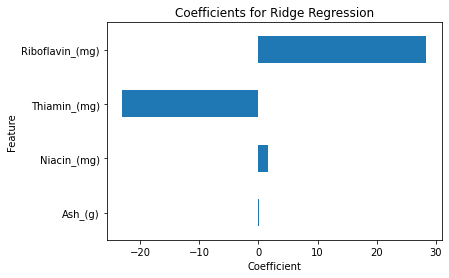

In [ ]:
## Ridge Model Coefficients ## -- Model is actually worse... Can we try limiting to two features...?
coefficients = model_r.coef_
features = X.columns ## model_r.named_steps['ridge'].get_feature_names() 
print(features, len(features), "=", len(coefficients)) ## VERIFY!
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(len(X)).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

In [ ]:
## BEST Features in regards to Prediction Column ##
best_feat_cols = ['Thiamin_(mg)', 'Riboflavin_(mg)', target]

## Keeping track of model performance ##
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val}, \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823, 13.67970857786769, 16.12868910885817], 
baseline mae: 13.282972880851371


# X. Second Impression - Third Wrangle

> The model has actually gotten worse by reducing from 25 features down to 4... can we improve it by using only 2 features??



In [ ]:
def wrangle(data_path):
  df = pd.read_csv(data_path,  
                   index_col= 'NDB_No') ## Set Index (Unique) -- Is a Unique index col still calculated??

  ## Drop Constant Columns
  cons_cols = [col for col in df.columns
              if df[col].nunique() == 1]
  df.drop(columns=cons_cols, inplace=True)
  print("Constant Columns Dropped:", cons_cols)

  ## Drop Columns Missing Over 90% of the Data ##
  percent_of_data = .10 # adjust this parameter to drop more or less columns...
  empty_threshold = len(df) * percent_of_data
  empty_max_cols = [col for col in df.columns
                    if df[col].isnull().sum() > empty_threshold]
  df.drop(columns=empty_max_cols, inplace=True)
  print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

   ## Drop Columns Missing Half of the Data ##
  cutoff = int(len(df)/2)
  empty_cols = [col for col in df.columns
               if (df[col].isnull().sum() > cutoff)]
  df.drop(columns=empty_cols, inplace=True)
  print("Columns Dropped with Over Half Missing Values:", empty_cols)

  ## Drop HCCCs
  cutoff = 100
  hcc_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  uni_cols = [col for col in df.columns
              if df[col].nunique() == len(df)]
  df.drop(columns= hcc_cols + uni_cols, inplace=True)
  print("High Cardinality Columns Dropped:", hcc_cols, 
        "\nUnique Columns Dropped:", uni_cols)
  
  ## Drop Rows that have NaN Values ## -- 
  og_rows = len(df)
  df = df.dropna()
  print(og_rows - len(df), 'rows with NaN values dropped!!')

  #Special Drops that are half-empty, HCC, or Unique:
  not_best_feat_cols = [col for col in df.columns 
                       if col not in best_feat_cols]
  df.drop(columns= not_best_feat_cols, inplace=True)
  print("All But these Columns Dropped:", best_feat_cols)

  return df
df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: []
2267 rows with NaN values dropped!!
All But these Columns Dropped: ['Thiamin_(mg)', 'Riboflavin_(mg)', 'Vit_C_(mg)']


In [ ]:
## RERUN Pandas Profile Report ##
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/12 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
target = 'Vit_C_(mg)' ## Prediction Col
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

In [ ]:
y_pred = [y.mean()] * len(y) 
base_mae = mean_absolute_error(y,y_pred)
print('BASELINE MAE:', base_mae) ## This is the score to beat

BASELINE MAE: 13.282972880851371


In [ ]:
## Linear Regression Model ##
model_lr = make_pipeline(
    LinearRegression())

model_lr.fit(X_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
print('model_lr MAE for training', mean_absolute_error(y_train, model_lr.predict(X_train)))
print('model_lr MAE for val',mean_absolute_error(y_val, model_lr.predict(X_val)) )

model_lr MAE for training 12.937011648194222
model_lr MAE for val 15.33251689157873


In [ ]:
## Standard Ridge Regression Model ##
model_std_r = Ridge(alpha=1)
model_std_r.fit(X_train,y_train)
print('model_std_r MAE for training', mean_absolute_error(y_train, model_std_r.predict(X_train)))
print('model_std_r MAE for val',mean_absolute_error(y_val, model_std_r.predict(X_val)) )

model_std_r MAE for training 12.931480040925933
model_std_r MAE for val 15.32618018965436


In [ ]:
## Ridge Regression Model -- Set TUNE to '1'' to run!!##
## ALPHA TUNE ##
best_low_alpha, last_mae_val, cont = 0, [base_mae**2], 'start'
tune = 1
factor = .1 ## Change in multiples of ten to process alpha faster (.10,1,10,100,etc.)
range_max = 10
while tune == True:
  for i in range (0,range_max):
    model_r = Ridge(alpha=(i*factor)) # Iterates Alpha hyperparameter
    model_r.fit(X_train,y_train)
    r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
    r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
    last_mae_val.append(r_mae_val)
    if (i % (1000)) == 0: ## Printing for big iterations
      print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-2]}"))
    if r_mae_val < base_mae: ## Returning the first best alpha
      best_low_alpha = i*factor
      print(f"\nbest_low_alpha: {best_low_alpha}\nr_mae_train: {r_mae_train}\nr_mae_val: {r_mae_val}\nlast_mae_val: {last_mae_val[-1]}")
      tune == False
    if r_mae_val > last_mae_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
      best_low_alpha = (i-1)*factor
      print(f"\nLAST MAE VAL HIGHER!! \n best_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
      tune = False
      if tune == False and cont.lower().strip() != 'y':
        cont = input("\nWould you like to continue? y/n: ")
        if cont.lower().strip() != 'n':
          tune = True
        else:  
          best_low_alpha = i*factor
          print(f"\n--FINAL--\nbest_low_alpha: {best_low_alpha}\nlast_mae_val: {last_mae_val[-2]}\nr_mae_val: {r_mae_val}")
          tune = False
          break
    if int(i) == range_max-1:
      tune = False
      break

## BEST Ridge Regression Model with Best Alpha ##
model_r = Ridge(alpha=(best_low_alpha))
model_r.fit(X_train,y_train)
r_mae_train = mean_absolute_error(y_train, model_r.predict(X_train))
r_mae_val = mean_absolute_error(y_val, model_r.predict(X_val))
print(f"\n-- BEST Ridge Model--\nbest_low_alpha: {best_low_alpha}\nr_mae_val:" 
    f"{r_mae_val}\nbase_mae: {base_mae}")



I'm Still Running!!
alpha: 0.0
r_mae_train: 12.937011648194217
r_mae_val: 15.332516891578729
last_mae_val: 176.43736855343298
None

-- BEST Ridge Model--
best_low_alpha: 0
r_mae_val:15.332516891578729
base_mae: 13.282972880851371


In [ ]:
## Keeping track of model performance ##
model_mae_val.append(r_mae_val)
print(f"model_mae_vals: {model_mae_val}, \nbaseline mae: {base_mae}")

model_mae_vals: [18.846118620646823, 13.67970857786769, 16.12868910885817, 15.332516891578729], 
baseline mae: 13.282972880851371


# -- First Thesis / Thoughts: --

> Using Ridge Regression and limiting my features from 25 to 2, I wasn't
able to better my model. My validation mean absolute error in the 
best model was still higher than the baseline.

 Therefore, I am thinking there is little in relation to predicting
 Vitamin C content through any of these 25 features. However, I've 
 only been able to use linear and ridge regression.



# I. Re-examining as a Classification Problem - Wrangle Data

> Perhaps by reframing this as a classification problem, we can arrive at a different conclusion. We will try and encode and re-classify the sets
we've done before. Removing as many null values as possible (as per the documentation, this has more to do with recording error)



In [ ]:
def wrangle(data_path):
  df = pd.read_csv(data_path,  
                  #  index_col= 'NDB_No' ## Set Index (Unique) -- Is a Unique index col still calculated??
                   ) 

  ## Drop Constant Columns
  cons_cols = [col for col in df.columns
              if df[col].nunique() == 1]
  df.drop(columns=cons_cols, inplace=True)
  print("Constant Columns Dropped:", cons_cols)

  ## Drop Columns Missing Over 90% of the Data ##
  percent_of_data = .10 # adjust this parameter to drop more or less columns...
  empty_threshold = len(df) * percent_of_data
  empty_max_cols = [col for col in df.columns
                    if df[col].isnull().sum() > empty_threshold]
  df.drop(columns=empty_max_cols, inplace=True)
  print("Columns Dropped with Over",(1 - percent_of_data)*100,"% Missing Values:", empty_max_cols)

   ## Drop Columns Missing Half of the Data ##
  cutoff = int(len(df)/2)
  empty_cols = [col for col in df.columns
               if (df[col].isnull().sum() > cutoff)]
  df.drop(columns=empty_cols, inplace=True)
  print("Columns Dropped with Over Half Missing Values:", empty_cols)

  ## Drop HCCCs
  cutoff = 100
  hcc_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  uni_cols = [col for col in df.columns
              if df[col].nunique() == len(df)]
  df.drop(columns= hcc_cols + uni_cols, inplace=True)
  print("High Cardinality Columns Dropped:", hcc_cols, 
        "\nUnique Columns Dropped:", uni_cols)
  
  ## Drop Rows that have NaN Values ## -- 
  og_rows = len(df)
  df = df.dropna()
  print(og_rows - len(df), 'rows with NaN values dropped!!')

  ## Special Drops that are half-empty, HCC, or Unique: ##
  # not_best_feat_cols = [col for col in df.columns 
  #                      if col not in best_feat_cols]
  # df.drop(columns= not_best_feat_cols, inplace=True)
  # print("All But these Columns Dropped:", best_feat_cols)

  ## Columns that passed previous conditions that should be dropped: ##
  non_bin = ['Energ_Kcal', 'Refuse_Pct', 'GmWt_1']
  df.drop(columns= non_bin, inplace=True)

  ## Manually Encode the Remaining Columns
  content = df > 0
  df.mask(content, other=1, inplace=True)
  df = df.astype(int) ## change to integer
  df = df.astype(bool) ## change to object

  return df
df = wrangle(data_path)

Constant Columns Dropped: []
Columns Dropped with Over 90.0 % Missing Values: ['Sugar_Tot_(g)', 'Copper_mg)', 'Manganese_(mg)', 'Selenium_(µg)', 'Panto_Acid_mg)', 'Vit_B6_(mg)', 'Folate_Tot_(µg)', 'Folic_Acid_(µg)', 'Food_Folate_(µg)', 'Folate_DFE_(µg)', 'Choline_Tot_ (mg)', 'Vit_B12_(µg)', 'Vit_A_RAE', 'Retinol_(µg)', 'Alpha_Carot_(µg)', 'Beta_Carot_(µg)', 'Beta_Crypt_(µg)', 'Lycopene_(µg)', 'Lut+Zea_ (µg)', 'Vit_E_(mg)', 'Vit_D_µg', 'Vit_D_IU', 'Vit_K_(µg)', 'GmWt_2', 'GmWt_Desc2']
Columns Dropped with Over Half Missing Values: []
High Cardinality Columns Dropped: ['Shrt_Desc', 'GmWt_Desc1'] 
Unique Columns Dropped: ['NDB_No']
2267 rows with NaN values dropped!!


# II. Manually Encode the Columns - After Basic Wrangle

> We will manually encode the columns by assuming that any nutrient's content greater than zero will result in a binary classification of 'True' and 'False'  otherwise. This has been masked from integer to boolean within the dataframe.



In [ ]:
print(df.info())
df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 0 to 8789
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Water_(g)        6523 non-null   bool 
 1   Protein_(g)      6523 non-null   bool 
 2   Lipid_Tot_(g)    6523 non-null   bool 
 3   Ash_(g)          6523 non-null   bool 
 4   Carbohydrt_(g)   6523 non-null   bool 
 5   Fiber_TD_(g)     6523 non-null   bool 
 6   Calcium_(mg)     6523 non-null   bool 
 7   Iron_(mg)        6523 non-null   bool 
 8   Magnesium_(mg)   6523 non-null   bool 
 9   Phosphorus_(mg)  6523 non-null   bool 
 10  Potassium_(mg)   6523 non-null   bool 
 11  Sodium_(mg)      6523 non-null   bool 
 12  Zinc_(mg)        6523 non-null   bool 
 13  Vit_C_(mg)       6523 non-null   bool 
 14  Thiamin_(mg)     6523 non-null   bool 
 15  Riboflavin_(mg)  6523 non-null   bool 
 16  Niacin_(mg)      6523 non-null   bool 
 17  Vit_A_IU         6523 non-null   bool 
 18  FA_Sat_(

Water_(g)  Protein_(g)  Lipid_Tot_(g)  Ash_(g)  Carbohydrt_(g)  \
0          True         True           True     True            True   
1          True         True           True     True            True   
2          True         True           True    False           False   
3          True         True           True     True            True   
4          True         True           True     True            True   
...         ...          ...            ...      ...             ...   
8785       True         True           True     True           False   
8786       True         True           True     True            True   
8787       True        False          False     True            True   
8788       True         True           True     True            True   
8789       True         True           True     True           False   

      Fiber_TD_(g)  Calcium_(mg)  Iron_(mg)  Magnesium_(mg)  Phosphorus_(mg)  \
0            False          True       True            True             True   
1            False          True       True            True             True   
2            False          True      False           False             True   
3            False          True       True            True             True   
4            False          True       True            True             True   
...            ...           ...        ...             ...              ...   
8785         False          True       True            True             True   
8786         False          True       True            True             True   
8787         False          True       True            True             True   
8788         False          True       True            True             True   
8789         False          True       True            True             True   

      ...  Zinc_(mg)  Vit_C_(mg)  Thiamin_(mg)  Riboflavin_(mg)  Niacin_(mg)  \
0     ...       True       False          True             True         True   
1     ...       True       False          True             True         True   
2     ...       True       False          True             True         True   
3     ...       True       False          True             True         True   
4     ...       True       False          True             True         True   
...   ...        ...         ...           ...              ...          ...   
8785  ...       True       False          True             True         True   
8786  ...       True       False          True             True         True   
8787  ...       True       False          True             True         True   
8788  ...       True       False          True             True         True   
8789  ...       True       False          True             True         True   

      Vit_A_IU  FA_Sat_(g)  FA_Mono_(g)  FA_Poly_(g)  Cholestrl_(mg)  
0         True        True         True         True            True  
1         True        True         True         True            True  
2         True        True         True         True            True  
3         True        True         True         True            True  
4         True        True         True         True            True  
...        ...         ...          ...          ...             ...  
8785      True        True         True         True            True  
8786      True        True         True         True            True  
8787     False       False        False        False           False  
8788      True        True         True         True            True  
8789      True        True         True         True            True  

[6523 rows x 22 columns]

In [ ]:
## RERUN Pandas Profile Report ##
Report = ProfileReport(df,minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
target = 'Vit_C_(mg)' ## Prediction Col
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

In [ ]:
base_acc = y_train.value_counts(normalize=True).max()
print('baseline accuracy:', base_acc) ## This is the score to beat

baseline accuracy: 0.5331544653123802


In [ ]:
## Logisitic Regression ## -- Now usable in a classification model
model_log = make_pipeline(
    LogisticRegression()
)

model_log.fit(X_train, y_train)

Pipeline(steps=[('logisticregression', LogisticRegression())])

In [ ]:
model_log_acc = model_log.score(X_train, y_train)
model_log_val = model_log.score(X_val, y_val)
print('LOG: Training Accuracy:', model_log.score(X_train, y_train))
print('LOG: Validation Accuracy:', model_log.score(X_val, y_val))

LOG: Training Accuracy: 0.7736680720582598
LOG: Validation Accuracy: 0.7800766283524905


In [ ]:
## Decision Tree ## -- Now usable in a classification model
model_dt = make_pipeline(
    DecisionTreeClassifier()
)

model_dt.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())])

In [ ]:
model_dt_acc = model_dt.score(X_train, y_train)
model_dt_val = model_dt.score(X_val, y_val)
print('TREE: Training Accuracy:',model_dt_acc)
print('TREE: Validation Accuracy:', model_dt_val)

TREE: Training Accuracy: 0.7880413951705635
TREE: Validation Accuracy: 0.7854406130268199


In [ ]:
## Random Forest ## -- Now usable in a classification model
model_rf = make_pipeline(
    RandomForestClassifier()
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [ ]:
model_rf_acc = model_rf.score(X_train, y_train)
model_rf_val = model_rf.score(X_val, y_val)
print('RANDOM FOREST: Training Accuracy:', model_rf_acc)
print('RANDOM FOREST: Validation Accuracy:', model_rf_val)

RANDOM FOREST: Training Accuracy: 0.7880413951705635
RANDOM FOREST: Validation Accuracy: 0.7846743295019157


In [ ]:
## Keeping track of model performance ##
model_acc_val = []
model_acc_val.append("Log: " + str(model_log_acc) + " DT: " + str(model_dt_acc) + " RF: " + str(model_rf_acc))
print(f"model_acc_vals: {model_acc_val}, \nbaseline acc: {base_acc}")

model_acc_vals: ['Log: 0.7736680720582598 DT: 0.7880413951705635 RF: 0.7880413951705635'], 
baseline acc: 0.5331544653123802


# III. Evaluating Feature Importance

> Thus far, each classification model is better than our baseline. But let's see if we can hypertune them to be even better.



[ 0.81949372 -0.74189722 -0.44784057  0.03371828  1.26416333  0.99213483
  1.32540403 -0.75510519  0.6754824  -0.3373749   0.50027101 -0.41312079
 -0.39403131  0.53604412 -0.18852114  0.84324831  1.61411948  1.17371463
 -0.4908812  -0.293768   -0.59705832]


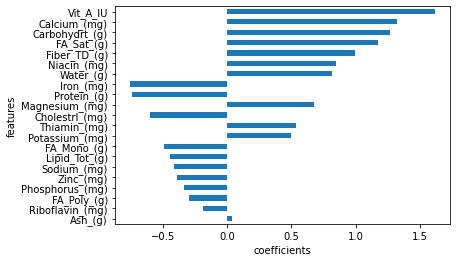

In [ ]:
coefficients = model_log.named_steps['logisticregression'].coef_[0]
print(coefficients)
features = X.columns
pd.Series(data=coefficients, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('coefficients');


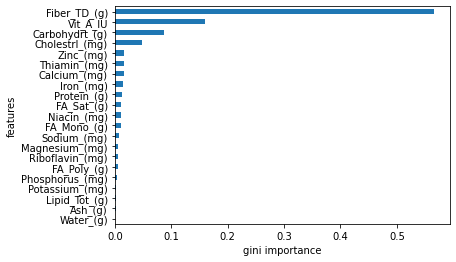

In [ ]:
## Decision Tree -- Feature Importance ##

features = X.columns
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

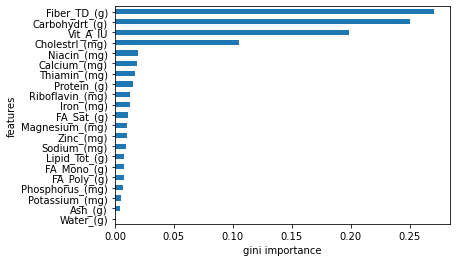

In [ ]:
## Random Forest -- Feature Importance ##
features = X.columns
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

#IV. Hypertuning

> Only getting a few hundreths improvement in accuracy score using hypertuning.
Perhaps the base models are best for generalization. 



In [ ]:
## Logisitic Regression -- Solver, Penalty (Regularization), and C (Penalty Strength) ##
print('LOG: Training Accuracy:', model_log.score(X_train, y_train))
print('LOG: Validation Accuracy:', model_log.score(X_val, y_val))
model_log = make_pipeline(
    LogisticRegression(solver='liblinear', penalty='l2', C=10)
)

model_log.fit(X_train, y_train)
model_log_acc = model_log.score(X_train, y_train)
model_log_val = model_log.score(X_val, y_val)
print('Tuned LOG: Training Accuracy:', model_log.score(X_train, y_train))
print('Tuned LOG: Validation Accuracy:', model_log.score(X_val, y_val))

LOG: Training Accuracy: 0.7736680720582598
LOG: Validation Accuracy: 0.7800766283524905
Tuned LOG: Training Accuracy: 0.7736680720582598
Tuned LOG: Validation Accuracy: 0.7816091954022989


In [ ]:
print('TREE: Training Accuracy:',model_dt_acc)
print('TREE: Validation Accuracy:', model_dt_val)
## Decision Tree -- Max Depth (of Tree) ##
model_dt = make_pipeline(
    DecisionTreeClassifier(max_depth= 50)
)

model_dt.fit(X_train, y_train)
model_dt_acc = model_dt.score(X_train, y_train)
model_dt_val = model_dt.score(X_val, y_val)
print('Tuned TREE: Training Accuracy:',model_dt_acc)
print('Tuned TREE: Validation Accuracy:', model_dt_val)

TREE: Training Accuracy: 0.7880413951705635
TREE: Validation Accuracy: 0.7854406130268199
Tuned TREE: Training Accuracy: 0.7880413951705635
Tuned TREE: Validation Accuracy: 0.7862068965517242


In [ ]:
## Random Forest -- Max Features, Max Depth, and n_estimators ##
print('RANDOM FOREST: Training Accuracy:', model_rf_acc)
print('RANDOM FOREST: Validation Accuracy:', model_rf_val)
best_max_depth = []
## Max Depths TUNE ##
best_max_depth, last_acc_val, cont = 0, [base_acc], 'start'
tune = 1
factor = 1 ## Change in multiples of ten to process hyperparameter faster (.10,1,10,100,etc.)
range_max = 40
while tune == True:
  for i in range (1,range_max):
    model_rf = RandomForestClassifier(max_depth=(i*factor)) # Iterates Max Depth hyperparameter
    model_rf.fit(X_train,y_train)
    model_rf_acc = model_rf.score(X_train, y_train)
    model_rf_val = model_rf.score(X_val, y_val)
    last_acc_val.append(model_rf_val)
    if (i % (1000)) == 0: ## Printing for big iterations
      print(print(f"\nI'm Still Running!!\nalpha: {i*factor}\nr_mae_train: {model_rf_acc}\nmodel_rf_val: {model_rf_val}\nlast_acc_val: {last_acc_val[-2]}"))
    # if model_rf_val < base_acc: ## Returning the first best alpha
    #   best_max_depth = i*factor
    #   print(f"\nbest_max_depth: {best_max_depth}\nr_mae_train: {model_rf_acc}\nmodel_rf_val: {model_rf_val}\nlast_acc_val: {last_acc_val[-1]}")
      # tune == False
    if model_rf_val < last_acc_val[-2] and cont.lower().strip() != 'n' and cont.lower().strip() != 'y': ## FLAG when stats get worse
      best_max_depth = (i-1)*factor
      print(f"\nLAST ACC VAL HIGHER!! \n best_max_depth: {best_max_depth}\nlast_acc_val: {last_acc_val[-2]}\nmodel_rf_val: {model_rf_val}")
      tune = False
      if tune == False and cont.lower().strip() != 'y':
        cont = input("\nWould you like to continue? y/n: ")
        if cont.lower().strip() != 'n':
          tune = True
        else:  
          best_max_depth = i*factor
          print(f"\n--FINAL--\nbest_max_depth: {best_max_depth}\nlast_acc_val: {last_acc_val[-2]}\nmodel_rf_val: {model_rf_val}")
          tune = False
          break
    if int(i) == range_max-1:
      tune = False
      break

## BEST Random Forest Model with Best Max Depth ##
model_rf = make_pipeline(
    RandomForestClassifier(max_depth=(best_max_depth))
    )
model_rf.fit(X_train,y_train)
model_rf_acc = model_rf.score(X_train, y_train)
model_rf_val = model_rf.score(X_val, y_val)
print(f"\n-- BEST Random Forest Model--\nbest_max_depth: {best_max_depth}\nmodel_rf_val:" 
    f"{model_rf_val}\nbase_acc: {base_acc}")

RANDOM FOREST: Training Accuracy: 0.754120352625527
RANDOM FOREST: Validation Accuracy: 0.7670498084291187

LAST ACC VAL HIGHER!! 
 best_max_depth: 5
last_acc_val: 0.7869731800766283
model_rf_val: 0.7862068965517242

Would you like to continue? y/n: n

--FINAL--
best_max_depth: 6
last_acc_val: 0.7869731800766283
model_rf_val: 0.7862068965517242

-- BEST Random Forest Model--
best_max_depth: 6
model_rf_val:0.7716475095785441
base_acc: 0.5331544653123802


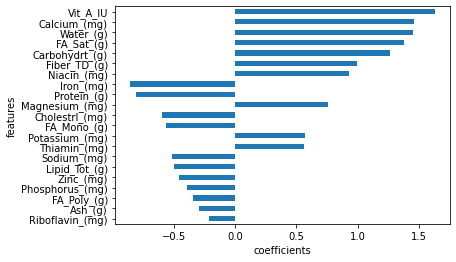

In [ ]:
coefficients = model_log.named_steps['logisticregression'].coef_[0]
features = X.columns
pd.Series(data=coefficients, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('coefficients');


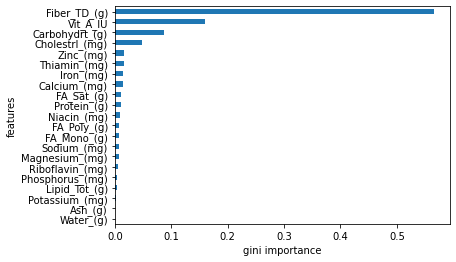

In [ ]:
## Decision Tree -- Feature Importance ##

features = X.columns
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

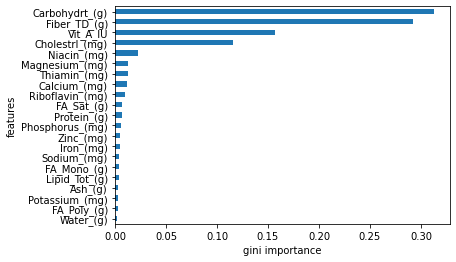

In [ ]:
## Random Forest -- Feature Importance ##
features = X.columns
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(25).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

#V. Test Set Predictions

In [ ]:
## Decision Tree -- Max Depth (of Tree) ##
# model_dt_acc = model_dt.score(X_train, y_train)
# model_dt_val = model_dt.score(X_val, y_val)
# model_dt_test = model_dt.predict(X_test)
# print('Tuned TREE: Training Accuracy:',model_dt_acc)
# print('Tuned TREE: Validation Accuracy:', model_dt_val)